In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from pycocotools.coco import COCO
import skimage.io as io
from tqdm.notebook import tqdm
import shutil

AUTOTUNE = tf.data.AUTOTUNE
print(f"TensorFlow Version: {tf.__version__}")

2025-11-07 13:14:03.372512: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762521243.542762      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762521243.589582      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

TensorFlow Version: 2.18.0


In [ ]:
print("--- 1. Setting up GPU and Paths ---")

# --- Constants ---
NUM_IMAGES_TO_PROCESS = 20000
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 32 

# --- TFRecord Setup ---
TFRECORD_DIR = "/kaggle/working/tfrecords"
TFRECORD_SHARDS = 16 # We'll split our data into 16 files
os.makedirs(TFRECORD_DIR, exist_ok=True)
print(f"Will save TFRecords to: {TFRECORD_DIR}")

# --- Original COCO data paths ---
dataDir = '/kaggle/input/coco-2017-dataset/coco2017'
dataType = 'train2017'
img_dir_original = os.path.join(dataDir, dataType)
annFile = os.path.join(dataDir, 'annotations', f'instances_{dataType}.json')

# --- Load COCO annotations ---
print("Loading annotations...")
coco = COCO(annFile)
print("Annotations loaded.")

# --- Get image IDs and paths ---
all_imgIds = coco.getImgIds()
imgIds_subset = all_imgIds[:NUM_IMAGES_TO_PROCESS]
print(f"Will process {len(imgIds_subset)} images.")

--- 1. Setting up GPU and Paths ---
Will save TFRecords to: /kaggle/working/tfrecords
Loading annotations...
loading annotations into memory...
Done (t=21.21s)
creating index...
index created!
Annotations loaded.
Will process 20000 images.


In [3]:
print("--- 2. Defining TFRecord Helper Functions (Byte-based) ---")

# --- Serialization Functions ---
# These convert our data into a format TFRecord can store

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # Get value out of EagerTensor
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def serialize_example(image_bytes, mask_bytes):
  """
  Creates a tf.train.Example message with raw image/mask bytes.
  """
  # Create a features dictionary
  feature = {
      'image': _bytes_feature(image_bytes),
      'mask': _bytes_feature(mask_bytes),
  }
  
  # Create a Features message using tf.train.Example
  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

print("Helper functions defined.")

--- 2. Defining TFRecord Helper Functions (Byte-based) ---
Helper functions defined.


In [4]:
print("--- 3. Creating TFRecord Files (with raw bytes) ---")
print("This will be much faster and save disk space.")

# --- Open all 16 file writers ---
writers = [
    tf.io.TFRecordWriter(
        os.path.join(TFRECORD_DIR, f"data_shard_{i:02d}.tfrecord")
    ) for i in range(TFRECORD_SHARDS)
]

for i, imgId in enumerate(tqdm(imgIds_subset, desc="Writing TFRecords")):
    try:
        # --- 1. Get Image Path ---
        img_info = coco.loadImgs([imgId])[0]
        img_path = os.path.join(img_dir_original, img_info['file_name'])
        
        if not os.path.exists(img_path):
            print(f"Warning: Missing file {img_path}")
            continue
        
        # --- 2. Load RAW Image Bytes ---
        image_bytes = tf.io.read_file(img_path)
        
        # --- 3. Generate Mask ---
        annIds = coco.getAnnIds(imgIds=imgId)
        anns = coco.loadAnns(annIds)
        height, width = img_info['height'], img_info['width']
        
        final_binary_mask = np.zeros((height, width), dtype=np.uint8)
        if anns:
            for ann in anns:
                mask = coco.annToMask(ann)
                final_binary_mask = np.logical_or(final_binary_mask, mask)
        
        # --- 4. Encode Mask as PNG Bytes ---
        mask_image_np = (final_binary_mask * 255).astype(np.uint8)
        # We must add a channel dimension for encode_png
        mask_image_np = np.expand_dims(mask_image_np, axis=-1)
        mask_bytes = tf.image.encode_png(mask_image_np)

        # --- 5. Serialize raw bytes ---
        example = serialize_example(image_bytes, mask_bytes.numpy())
        
        # --- 6. Write to a shard ---
        writer = writers[i % TFRECORD_SHARDS]
        writer.write(example)
        
    except Exception as e:
        print(f"\nError processing image {imgId}: {e}")

# --- Close all file writers ---
for writer in writers:
    writer.close()

print(f"\n--- TFRecord creation complete! ---")

--- 3. Creating TFRecord Files (with raw bytes) ---
This will be much faster and save disk space.


Writing TFRecords:   0%|          | 0/20000 [00:00<?, ?it/s]

I0000 00:00:1762521281.090738      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



--- TFRecord creation complete! ---


In [5]:
print("--- 4. Defining Pipeline and Model (with in-line processing) ---")

# --- 1. Define Data Pipeline Functions ---
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string), # raw image bytes
    'mask': tf.io.FixedLenFeature([], tf.string),  # raw mask bytes
}

# This function does all the processing
def _parse_and_process(example_proto):
    example = tf.io.parse_single_example(example_proto, feature_description)
    
    # --- Decode ---
    image = tf.image.decode_jpeg(example['image'], channels=3)
    mask = tf.image.decode_png(example['mask'], channels=1)
    
    # --- Resize ---
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method='nearest')
    
    # --- Normalize ---
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.vgg16.preprocess_input(image) # VGG normalization
    mask = tf.cast(mask, tf.float32) / 255.0 # Mask to [0, 1]
    
    # --- Set Shape ---
    image.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
    mask.set_shape([IMG_HEIGHT, IMG_WIDTH, 1])
    
    return image, mask

def augment_pair(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    return image, mask

# --- 2. Create Train/Validation Datasets ---
DATASET_SIZE = len(imgIds_subset)
TRAIN_SIZE = int(DATASET_SIZE * 0.8)
VAL_SIZE = DATASET_SIZE - TRAIN_SIZE

print(f"Total dataset size: {DATASET_SIZE}")
print(f"Training size: {TRAIN_SIZE}, Validation size: {VAL_SIZE}")

tfrecord_files = tf.io.gfile.glob(f"{TFRECORD_DIR}/*.tfrecord")
print(f"Found {len(tfrecord_files)} TFRecord shards.")

# Create the base dataset
ds = tf.data.TFRecordDataset(tfrecord_files, num_parallel_reads=AUTOTUNE)
ds = ds.map(_parse_and_process, num_parallel_calls=AUTOTUNE)

# --- THIS IS THE KEY ---
# We cache the *processed* data. The first epoch will be slow
# as it fills the cache. All other epochs will be lightning fast.
ds = ds.cache() 
print("Pipeline defined. Caching will occur on first epoch.")
    
train_ds_base = ds.take(TRAIN_SIZE)
val_ds_base = ds.skip(TRAIN_SIZE)

train_pipeline = (
    train_ds_base
    .shuffle(TRAIN_SIZE)
    .map(augment_pair, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_pipeline = (
    val_ds_base
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
print("Training and Validation pipelines created from TFRecords.")

# --- 3. Build the VGG16-U-Net Model (Same as before) ---
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import VGG16

def build_vgg16_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    skip_layer_names = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3']
    skip_outputs = [base_model.get_layer(name).output for name in skip_layer_names]
    bottleneck = base_model.get_layer('block5_conv3').output
    base_model.trainable = False 
    
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bottleneck)
    u6 = layers.concatenate([u6, skip_outputs[3]])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c6)
    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, skip_outputs[2]])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c7)
    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, skip_outputs[1]])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c8)
    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, skip_outputs[0]])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c9)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=base_model.input, outputs=[outputs])
    return model

# --- 4. Build and Compile the Model ---
model = build_vgg16_unet()
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.MeanIoU(num_classes=2)])

print("Model built and compiled successfully.")
model.summary()

--- 4. Defining Pipeline and Model (with in-line processing) ---
Total dataset size: 20000
Training size: 16000, Validation size: 4000
Found 16 TFRecord shards.
Pipeline defined. Caching will occur on first epoch.
Training and Validation pipelines created from TFRecords.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model built and compiled successfully.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 256, 256,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 128, 128,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 128, 128,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 128, 128,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 64, 64,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 64, 64,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 64, 64,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 64, 64,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 32, 32,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 32, 32,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 32, 32,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 32, 32,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 16, 16,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 16, 16,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 16, 16,    │  2,359,808 │ block5_conv1[0][

 Total params: 25,854,657 (98.63 MB)

 Trainable params: 11,139,969 (42.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [6]:
print("--- 5. Compiling and Training the Model ---")

EPOCHS = 10
print(f"Starting training for {EPOCHS} epochs on GPU...")

history = model.fit(
    train_pipeline,
    epochs=EPOCHS,
    validation_data=val_pipeline
)

print("--- Model training complete ---")
model.save('/kaggle/working/gpu_vgg_unet_tfrecord.keras')
print("Model saved to /kaggle/working/gpu_vgg_unet_tfrecord.keras")

--- 5. Compiling and Training the Model ---
Starting training for 10 epochs on GPU...
Epoch 1/10


I0000 00:00:1762521679.405649      97 service.cc:148] XLA service 0x78e768004410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762521679.406471      97 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1762521680.341302      97 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-11-07 13:21:26.665310: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=2} for conv (f32[32,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,128,128]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-11-07

    500/Unknown 375s 522ms/step - binary_accuracy: 0.6872 - loss: 5.3949 - mean_io_u: 0.3675

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


500/500 ━━━━━━━━━━━━━━━━━━━━ 471s 715ms/step - binary_accuracy: 0.6873 - loss: 5.3870 - mean_io_u: 0.3675 - val_binary_accuracy: 0.8329 - val_loss: 0.3842 - val_mean_io_u: 0.3566
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 293s 586ms/step - binary_accuracy: 0.8389 - loss: 0.3594 - mean_io_u: 0.3544 - val_binary_accuracy: 0.8637 - val_loss: 0.3279 - val_mean_io_u: 0.3569
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 293s 586ms/step - binary_accuracy: 0.8575 - loss: 0.3172 - mean_io_u: 0.3521 - val_binary_accuracy: 0.8668 - val_loss: 0.3027 - val_mean_io_u: 0.3570
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 293s 586ms/step - binary_accuracy: 0.8664 - loss: 0.3050 - mean_io_u: 0.3528 - val_binary_accuracy: 0.8721 - val_loss: 0.2933 - val_mean_io_u: 0.3555
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 293s 586ms/step - binary_accuracy: 0.8734 - loss: 0.2869 - mean_io_u: 0.3537 - val_binary_accuracy: 0.8718 - val_loss: 0.2934 - val_mean_io_u: 0.3572
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 293s 586ms/step - bin

--- 6. Plotting Training History ---


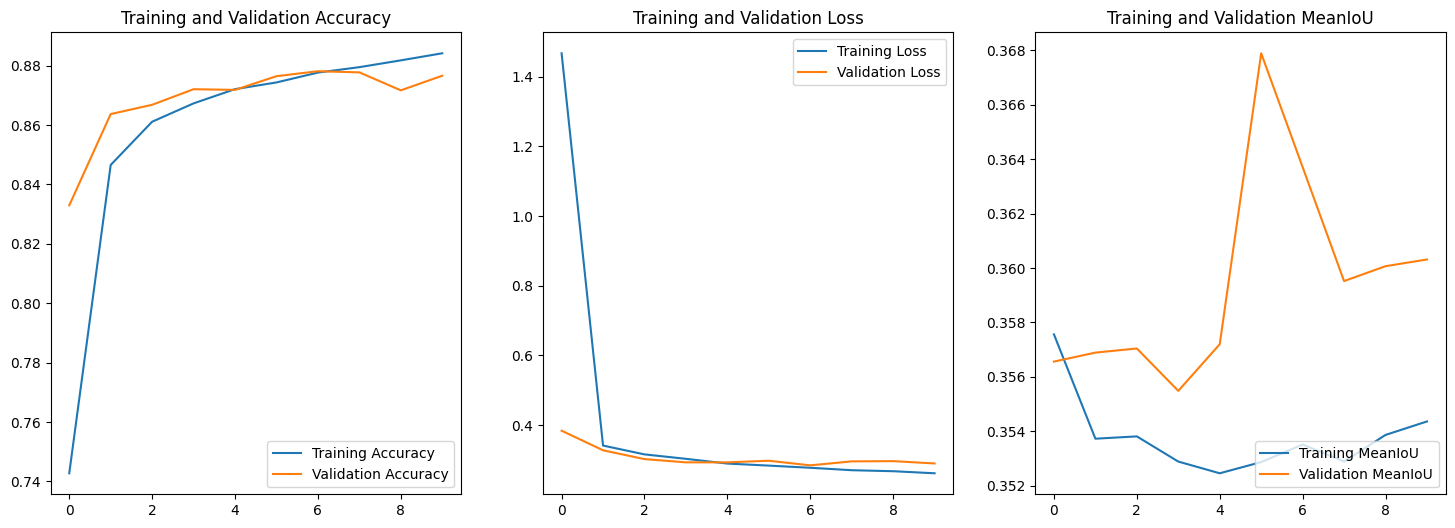

In [7]:
print("--- 6. Plotting Training History ---")

acc = history.history.get('binary_accuracy', [])
val_acc = history.history.get('val_binary_accuracy', [])
loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])
iou = history.history.get('mean_io_u', [])
val_iou = history.history.get('val_mean_io_u', [])

epochs_range = range(len(loss))

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, iou, label='Training MeanIoU')
plt.plot(epochs_range, val_iou, label='Validation MeanIoU')
plt.legend(loc='lower right')
plt.title('Training and Validation MeanIoU')

plt.show()

--- 7. Visualizing Model Predictions ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


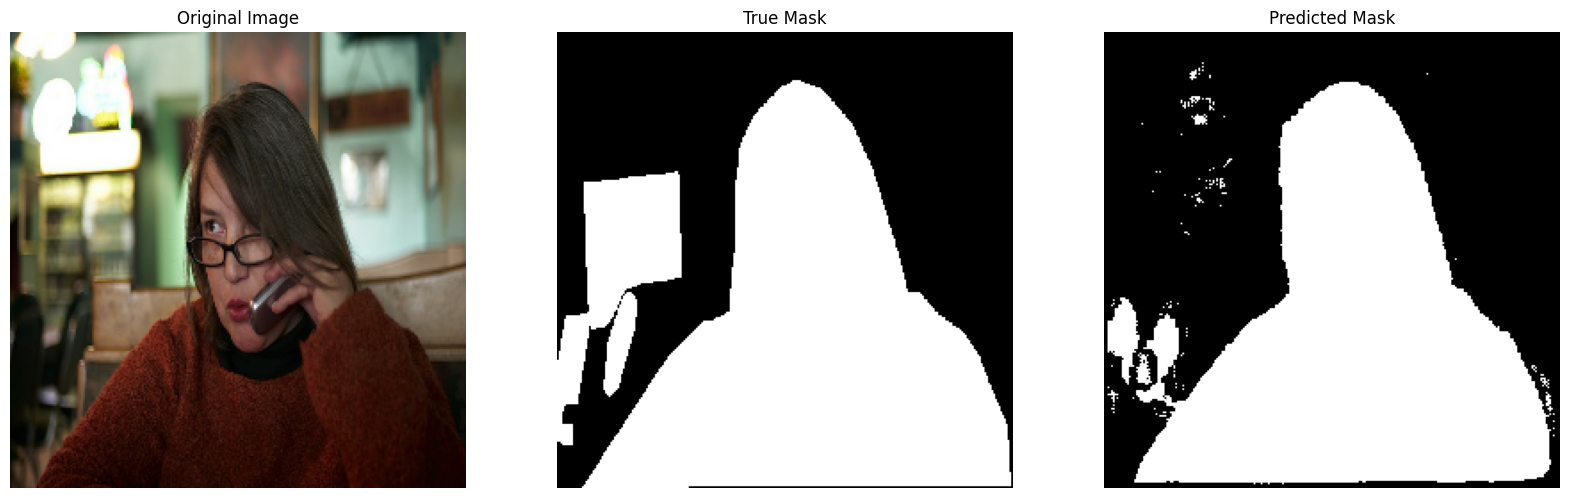

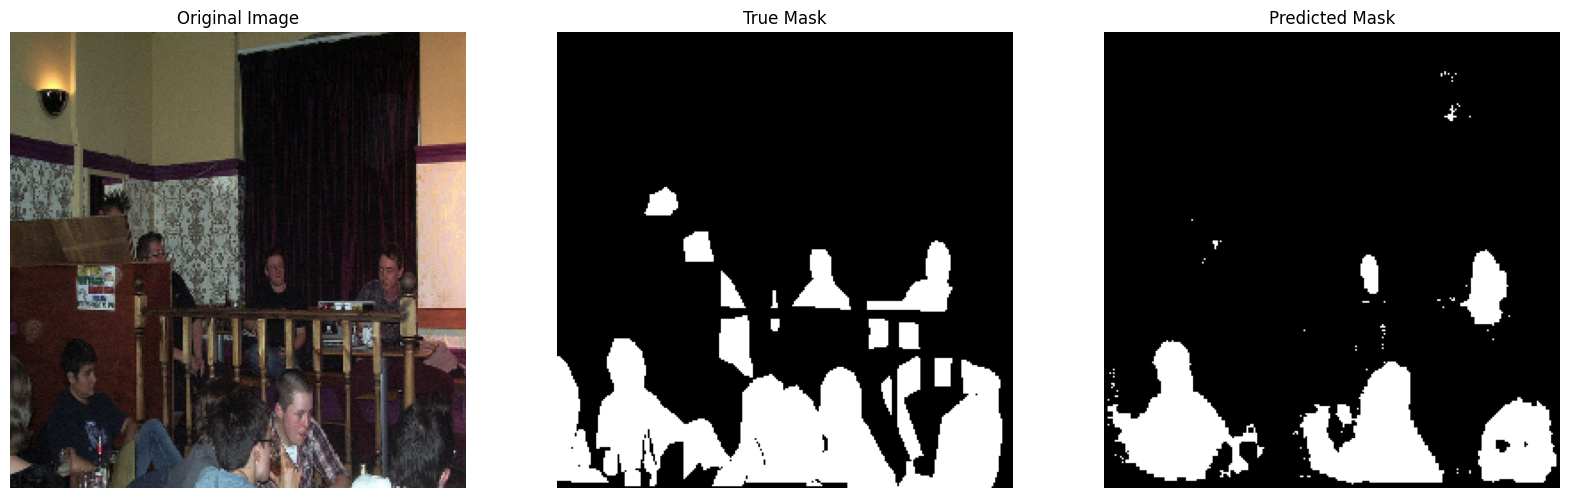

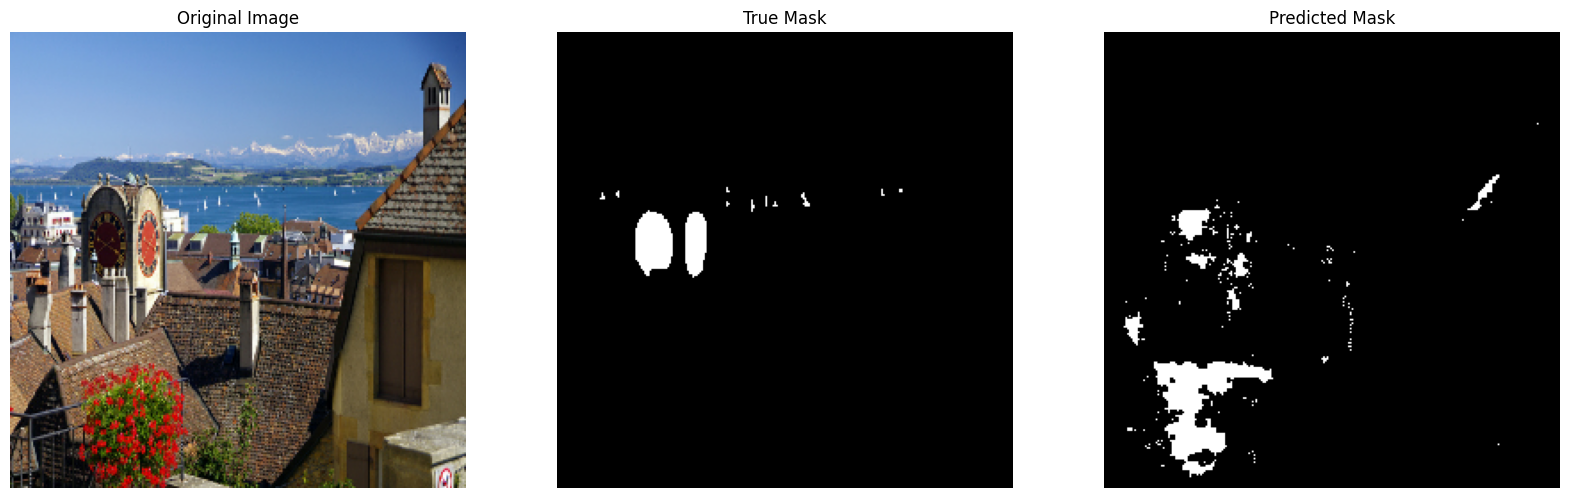

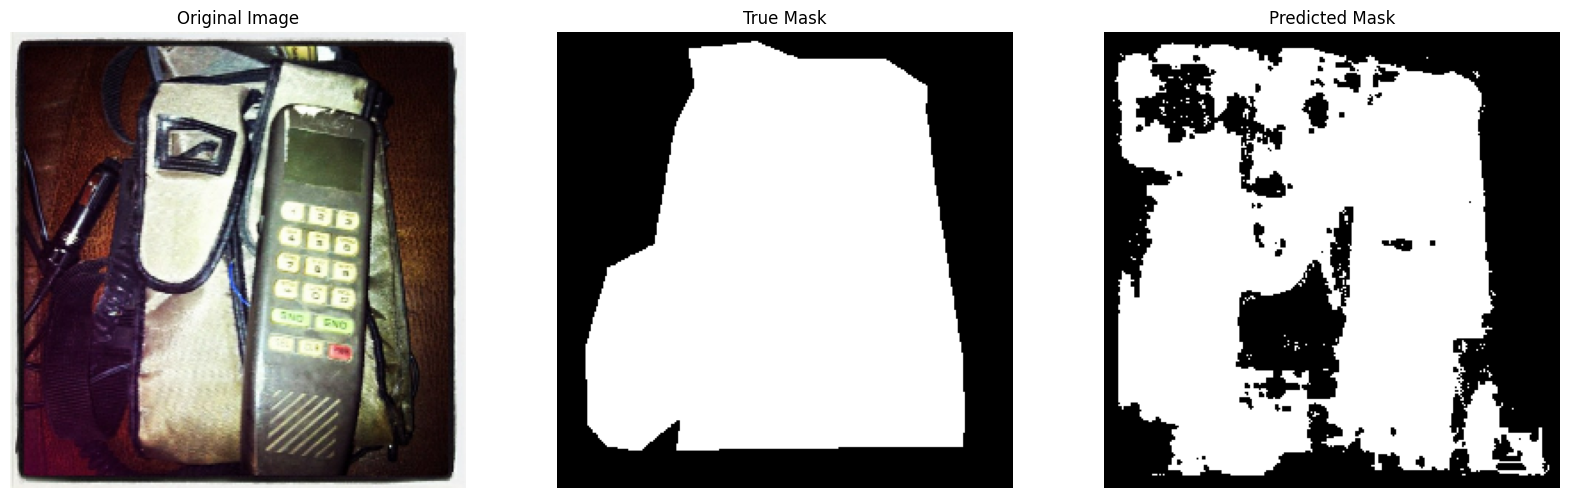

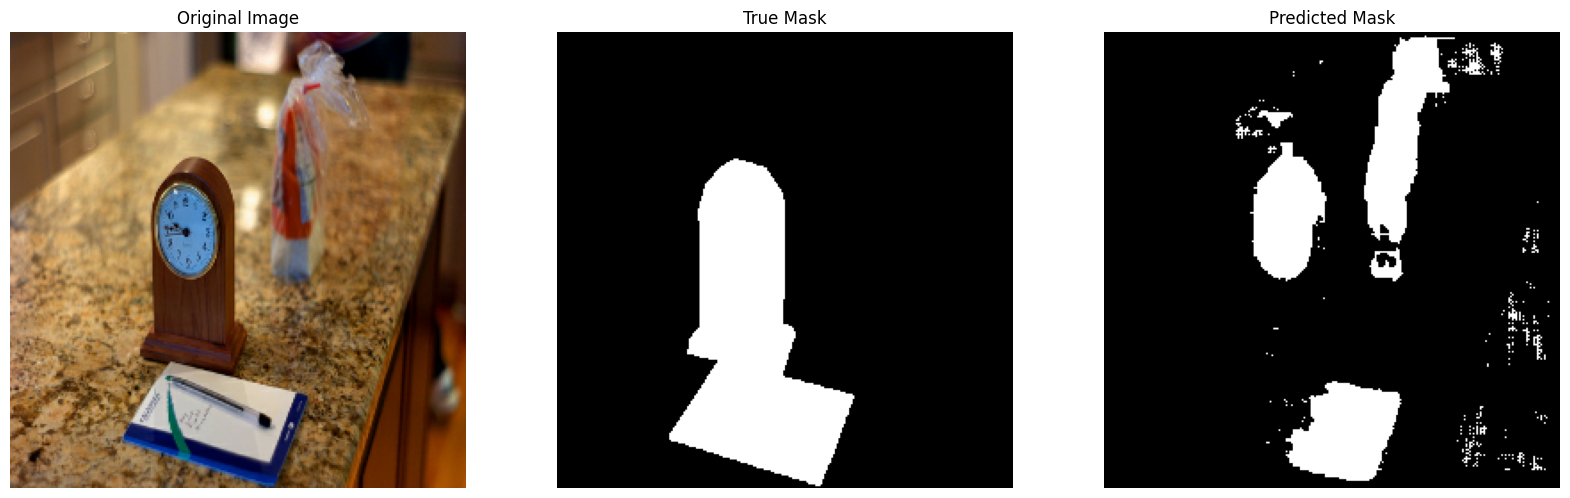

In [8]:
print("--- 7. Visualizing Model Predictions ---")

def deprocess_vgg_image(vgg_image):
    img = vgg_image.copy()
    img[..., 0] += 103.939
    img[..., 1] += 116.779
    img[..., 2] += 123.68
    img = img[..., ::-1] # BGR to RGB
    return np.clip(img, 0, 255).astype(np.uint8)

# Take one batch from the validation pipeline
for images, masks in val_pipeline.take(1):
    predictions = model.predict(images)
    
    # Display 5 predictions
    for i in range(5):
        if i >= len(images): break 
            
        fig, ax = plt.subplots(1, 3, figsize=(20, 7))
        
        display_image = deprocess_vgg_image(images[i].numpy())
        ax[0].imshow(display_image)
        ax[0].set_title("Original Image")
        ax[0].axis('off')
        
        ax[1].imshow(masks[i], cmap='gray')
        ax[1].set_title("True Mask")
        ax[1].axis('off')
        
        predicted_mask = (predictions[i] > 0.5).astype(np.uint8)
        ax[2].imshow(predicted_mask, cmap='gray')
        ax[2].set_title("Predicted Mask")
        ax[2].axis('off')
        
        plt.show()